In [1]:
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy as gp
import sys

sys.path.append("..")  # Adds the parent directory to the system path


# Gene-dependency scores from functional-genomics screens

This notebook assembles the analyses used to produce **Table B.1** in **Appendix B.2** (cited in **Chapter 5**). It screens for gene dependencies (from CRISPR knockout screens) associated with the expression level of a gene of interest (e.g., *MTUS1* / ATIP3) across cancer cell lines.

---

## 1) Load & explore data (optional)
- Load DepMap expression (log2(TPM+1)), cell-line metadata, and mutation features.  
- Explore and perform basic sanity checks (dimensions, missingness, key coverage) and quick exploratory summaries.

## 2) Define the analysis cohort
- Apply simple filters (e.g., tissue/subtype, TNBC).  
- Keep only the expression columns needed for correlation analyses.

## 3) Gene dependencies: correlation of expression with gene-effect scores
- Load CRISPR gene-effect (dependency) data.  
- For the selected gene, compute per-gene correlations between expression and gene-effect scores across cell lines. Report:
  - Pearson coefficients, *p*-values, FDR (Benjamini–Hochberg),  
  - Sample size per gene, with optional scatter + regression plots.

## 4) Pathway enrichment on significant/essential genes
- Run pathway/ontology enrichment on genes showing significant associations (and essentiality, if applicable).  
- Summarize enriched pathways with adjusted *p*-values and coverage to contextualize mechanistic hypotheses.



# 1. Explore cell-line data (Optionnal)

## Data Sources

The files located in the `./data` folder were downloaded from the following official resources:

- [DepMap portal](https://depmap.org/portal/data_page/?tab=allData)
- [Genomics of Drug Sensitivity in Cancer (GDSC)](https://www.cancerrxgene.org/downloads)

These datasets include genomic and pharmacological data used throughout this analysis.

## A. Mutation (cell Line Name/COSMIC_ID/GDSC Desc1/GDSC Desc2/TCGA Desc)


In the file `PANCANCER_Genetic_features.csv`, downloaded from  [Genomics of Drug Sensitivity in Cancer (GDSC)](https://www.cancerrxgene.org/downloads),  
we have access to the following information for each cell line:

- **Cell Line Name**
- **COSMIC_ID**
- **GDSC Desc1**
- **GDSC Desc2**
- **TCGA Desc**
- and the list of **mutations** identified in each sample.

In [2]:
# Load the genetic features dataset from a CSV file
Genetic_features = pd.read_csv("../data/Cell-lines/PANCANCER_Genetic_features_2025_04_07.csv")

# Rename the column 'COSMIC ID' to 'COSMIC_ID' for easier access and consistency
Genetic_features.rename(columns={'COSMIC ID': 'COSMIC_ID'}, inplace=True)

# Show to explore the dataset
# - the tumor type (TCGA Desc) is 'BRCA' (breast cancer)
# - and the genetic feature is 'KRAS_mut' (mutation in KRAS gene): only 2 cell-lines have this mutation
Genetic_features[(Genetic_features["TCGA Desc"] == 'BRCA') & 
                 (Genetic_features['Genetic Feature'] == 'KRAS_mut')]


/var/folders/zg/y03kdtc553xg5q1ct59rj44c0000gn/T/ipykernel_58885/4210660839.py:2: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  Genetic_features = pd.read_csv("../data/Cell-lines/PANCANCER_Genetic_features_2025_04_07.csv")


,Cell Line Name,COSMIC_ID,GDSC Desc1,GDSC Desc2,TCGA Desc,Genetic Feature,IS Mutated,Recurrent Gain Loss,Genes in Segment
1794,CAL-51,910927,breast,breast,BRCA,KRAS_mut,0,NaN,NaN
426320,COLO-824,906812,breast,breast,BRCA,KRAS_mut,0,NaN,NaN
427145,CAL-85-1,910852,breast,breast,BRCA,KRAS_mut,0,NaN,NaN
431528,CAMA-1,946382,breast,breast,BRCA,KRAS_mut,0,NaN,NaN
441500,CAL-120,906826,breast,breast,BRCA,KRAS_mut,0,NaN,NaN
446319,CAL-148,924106,breast,breast,BRCA,KRAS_mut,0,NaN,NaN
447226,AU565,910704,breast,breast,BRCA,KRAS_mut,0,NaN,NaN
448808,BT-20,906801,breast,breast,BRCA,KRAS_mut,0,NaN,NaN
450294,BT-474,946359,breast,breast,BRCA,KRAS_mut,0,NaN,NaN
451769,BT-483,949093,breast,breast,BRCA,KRAS_mut,0,NaN,NaN


In [3]:
# Create a new column with the mutated genes
def get_mutated_genes(row):
    mutated_genes = []

    # Check if the feature is marked as mutated
    if row['IS Mutated'] == 1:
        
        # Check if the gene name contains "_mut" in the 'Genetic Feature' column
        if '_mut' in row['Genetic Feature']:
            gene_name = row['Genetic Feature'].replace('_mut', '')
            mutated_genes.append(gene_name)
        
        # Optionally, check for genes listed in the 'Genes in Segment' column
        # Uncomment the following block if you want to include these genes as well
        # if pd.notna(row['Genes in Segment']):
        #     genes_list = row['Genes in Segment'].split(',')
        #     mutated_genes.extend(genes_list)
    
    # Return a list of unique gene names (remove duplicates)
    return list(set(mutated_genes))

# Apply the function to each row of the DataFrame to create the 'Mutated Genes' column
Genetic_features['Mutated Genes'] = Genetic_features.apply(get_mutated_genes, axis=1)

# Aggregate genetic features by cell line, keeping the first descriptions and merging unique mutated genes per group
grouped_Genetic_features = Genetic_features.groupby(['Cell Line Name', 'COSMIC_ID']).agg({
    'GDSC Desc1': 'first',
    'GDSC Desc2': 'first',
    'TCGA Desc': 'first',
    'Mutated Genes': lambda x: list(set([gene for sublist in x for gene in sublist]))
}).reset_index()
grouped_Genetic_features.head()


,Cell Line Name,COSMIC_ID,GDSC Desc1,GDSC Desc2,TCGA Desc,Mutated Genes
0,22RV1,924100,urogenital_system,prostate,PRAD,"[INPPL1, TP53BP1, CUX1, MLL2, ASH1L, ARID1A, R..."
1,23132-87,910924,digestive_system,stomach,STAD,"[LRPPRC, TP53BP1, ARID1A, FGFR2, SACS, CDKN1A,..."
2,42-MG-BA,687561,nervous_system,glioma,GBM,"[TP53, STAG2, RB1, PTEN]"
3,451Lu,1287706,skin,melanoma,SKCM,"[TP53, ROBO2, BRAF]"
4,5637,687452,urogenital_system,bladder,BLCA,"[POLR2B, TP53, ERBB2, RB1]"


In [4]:
TCGA_type = 'BRCA'  # Example TCGA type, can be changed as needed
# Filter the grouped DataFrame for a specific TCGA type (e.g., 'BRCA')
print("number of cell-lines:",len(grouped_Genetic_features[(grouped_Genetic_features["TCGA Desc"] == TCGA_type)]))

number of cell-lines: 51


In [5]:
# List of cell lines with specific mutated genes
list_mut = ['KRAS','BRAF']#,'HRAS','BRAF']
grouped_Genetic_features[(grouped_Genetic_features["TCGA Desc"] == 'BRCA') & (grouped_Genetic_features["Mutated Genes"].apply(lambda x: any(gene in x for gene in list_mut)))]

,Cell Line Name,COSMIC_ID,GDSC Desc1,GDSC Desc2,TCGA Desc,Mutated Genes
173,DU-4475,906844,breast,breast,BRCA,"[APC, BRAF]"
469,MDA-MB-231,905960,breast,breast,BRCA,"[ARFGEF1, NF2, FTSJD1, KRAS, NF1, TP53, BRWD1,..."
963,YMB-1-E,1303911,breast,breast,BRCA,"[MEN1, MLLT4, KRAS, FAT2, PTEN]"


## B. Metadata (DepMap_ID / COSMICID)

In the file `Model.csv`, downloaded from the  [DepMap portal](https://depmap.org/portal/data_page/?tab=allData),  
we have access to metadata describing all cancer models (cell lines) that are referenced by datasets included in the DepMap portal.  
This includes key identifiers such as **DepMap_ID** and **COSMICID**.

In [6]:
meta = pd.read_csv("../data/Cell-lines/Model.csv") 
meta.rename(columns={'ModelID': 'DepMap_ID','COSMICID': 'COSMIC_ID'}, inplace=True)
meta[meta["COSMIC_ID"] == 906863]

,DepMap_ID,PatientID,CellLineName,StrippedCellLineName,DepmapModelType,OncotreeLineage,OncotreePrimaryDisease,OncotreeSubtype,OncotreeCode,PatientSubtypeFeatures,...,EngineeredModelDetails,CulturedResistanceDrug,PublicComments,CCLEName,HCMIID,ModelAvailableInDbgap,ModelSubtypeFeatures,WTSIMasterCellID,SangerModelID,COSMIC_ID
842,ACH-000846,PT-tolPHE,FaDu,FADU,HPHSC,Head and Neck,Head and Neck Squamous Cell Carcinoma,Hypopharynx Squamous Cell Carcinoma,HPHSC,NaN,...,NaN,NaN,NaN,FADU_UPPER_AERODIGESTIVE_TRACT,NaN,Available in SRA,NaN,1170.0,SIDM00860,906863.0


In [7]:
meta_grouped_Genetic_features = meta.merge(grouped_Genetic_features, on='COSMIC_ID')
meta_grouped_Genetic_features

,DepMap_ID,PatientID,CellLineName,StrippedCellLineName,DepmapModelType,OncotreeLineage,OncotreePrimaryDisease,OncotreeSubtype,OncotreeCode,PatientSubtypeFeatures,...,ModelAvailableInDbgap,ModelSubtypeFeatures,WTSIMasterCellID,SangerModelID,COSMIC_ID,Cell Line Name,GDSC Desc1,GDSC Desc2,TCGA Desc,Mutated Genes
0,ACH-000001,PT-gj46wT,NIH:OVCAR-3,NIHOVCAR3,HGSOC,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,HGSOC,NaN,...,Available in SRA,NaN,2201.0,SIDM00105,905933.0,OVCAR-3,urogenital_system,ovary,OV,"[TP53, PIK3R1]"
1,ACH-000002,PT-5qa3uk,HL-60,HL60,AML,Myeloid,Acute Myeloid Leukemia,Acute Myeloid Leukemia,AML,"TP53(del), CDKN2A and NRAS mutations [PubMed=2...",...,Available in SRA,NaN,55.0,SIDM00829,905938.0,HL-60,blood,acute_myeloid_leukaemia,LAML,"[CDKN2A, NRAS]"
2,ACH-000004,PT-q4K2cp,HEL,HEL,AML,Myeloid,Acute Myeloid Leukemia,Acute Myeloid Leukemia,AML,"JAK2 and TP53 mutations,",...,Available in SRA,NaN,783.0,SIDM00594,907053.0,HEL,blood,acute_myeloid_leukaemia,LAML,[]
3,ACH-000006,PT-ej13Dz,MONO-MAC-6,MONOMAC6,AMOL,Myeloid,Acute Myeloid Leukemia,Acute Monoblastic/Monocytic Leukemia,AMOL,"KMT2A-MLLT3, TP53 Arg273His",...,Available in SRA,NaN,2167.0,SIDM01023,908148.0,MONO-MAC-6,blood,acute_myeloid_leukaemia,LAML,"[TP53, U2AF1, ASXL1]"
4,ACH-000007,PT-NOXwpH,LS513,LS513,COAD,Bowel,Colorectal Adenocarcinoma,Colon Adenocarcinoma,COAD,NaN,...,Available in SRA,NaN,569.0,SIDM00677,907795.0,LS-513,digestive_system,large_intestine,COREAD,"[ACVR2A, RASA2, KRAS, BRAF]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,ACH-002312,PT-wDUj8m,TGBC24TKB,TGBC24TKB,GBAD,Biliary Tract,Intracholecystic Papillary Neoplasm,"Gallbladder Adenocarcinoma, NOS",GBAD,NaN,...,NaN,NaN,2046.0,SIDM00267,910695.0,TGBC24TKB,digestive_system,biliary_tract,UNCLASSIFIED,"[APC, PBRM1, TP53, MLL2]"
942,ACH-002313,PT-lS0UAl,TK,TK,MBN,Lymphoid,Non-Hodgkin Lymphoma,Mature B-Cell Neoplasms,MBN,NaN,...,NaN,NaN,851.0,SIDM00323,1331045.0,TK,blood,B_cell_lymphoma,DLBC,"[TP53, MLL2]"
943,ACH-002314,PT-ZwaNYv,TUR,TUR,AMOL,Myeloid,Acute Myeloid Leukemia,Acute Monoblastic/Monocytic Leukemia,AMOL,"PICALM-MLLT10, with PTEN, PTPN11, TP53, and WT...",...,NaN,NaN,6.0,SIDM01205,909773.0,TUR,blood,B_cell_lymphoma,DLBC,"[RNF43, MED12, WT1, TP53, PTEN]"
944,ACH-002316,PT-I32vbo,WIL2-NS,WIL2NS,HSP,Myeloid,Hereditary Spherocytosis,Spherocytosis,NaN,"SPTA1 Ser1163Ala, TP53 Met237Ile",...,NaN,NaN,1470.0,SIDM01102,1331049.0,WIL2-NS,blood,lymphoid_neoplasm_other,UNCLASSIFIED,"[MLL3, TP53, KRAS]"


In [8]:
TCGA_type = 'BRCA'  # Example TCGA type, can be changed as needed
print("number of cell-lines:",len(meta_grouped_Genetic_features[(meta_grouped_Genetic_features["TCGA Desc"] == TCGA_type)]))

number of cell-lines: 49


## C. Gene expression Gene Expression (DepMap 24Q4)

We use the file `OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected.csv` from the  [DepMap portal](https://depmap.org/portal/download/), which contains batch-corrected log-transformed TPM values  for protein-coding genes across cancer cell lines.

1673 cell lines/ 19139 genes

In [10]:
# Load DepMap 24Q4 expression data (log-transformed TPM, batch corrected)
# Set 'DepMap_ID' as a column instead of index
# Clean column names by removing anything in parentheses and trimming whitespace
df = pd.read_csv("../data/Cell-lines/OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected.csv", index_col=0) #DepMap Public 24Q4
df.index.name = 'DepMap_ID'
df = df.reset_index()
df.columns = df.columns.str.extract(r'^([^\(]+)', expand=False).str.strip()
df.rename(columns={'COSMICID': 'COSMIC_ID'}, inplace=True)
print(df.shape)
df.head(5)
#df = df[['DepMap_ID','MTUS1','MYC','MAPT','MAPK3','MAPK1','MAP2K1','MAP2K2','JAK1','JAK2','JAK3','AKT1','AKT2','AKT3','PIK3CA','KRAS', 'BRAF', 'NRAS','RAF1','HRAS','KIF2A','MAST4',]]

(1673, 19139)


,DepMap_ID,TFE3,MMADHC,PABPC1L,RELL2,GPT,GUSB,H4-16,DDB2,RPS4X,...,OR2A42,HOXB7,NSA2,UGT2B11,ZNF747,NAA60,MYH4,MTAP,C14orf93,NR3C2
0,ACH-000873,3.607691,3.531071,4.982285,2.326016,0.607679,5.118549,1.282028,4.512297,10.075438,...,0.042564,3.870581,5.178480,-0.007723,2.005498,4.213717,-0.001724,3.904800,2.190931,0.203910
1,ACH-000860,4.192566,6.865682,4.853288,2.725583,0.197016,5.666426,1.154470,4.306808,10.215240,...,0.031621,-0.005897,6.749713,-0.007723,1.393644,4.334535,-0.001724,4.812949,3.366939,0.370726
2,ACH-000439,3.265517,5.804615,1.777636,4.185835,0.389025,6.593342,0.410244,4.411381,11.644890,...,-0.013226,-0.033868,6.877322,1.596383,3.143557,4.624226,-0.001724,4.122929,2.197136,0.015412
3,ACH-000318,3.705500,5.813170,4.536005,2.290409,0.471169,5.160089,2.325673,5.017968,9.163992,...,-0.013226,3.051092,5.610027,-0.007723,2.334419,3.881219,-0.001724,0.394778,3.217293,0.277760
4,ACH-001142,6.105227,7.051513,4.457555,2.543055,0.022363,4.589966,2.369987,4.105131,10.179188,...,0.053402,3.582671,7.416571,-0.007723,2.294077,4.889203,-0.001724,4.379944,2.355443,0.520338


# 2. Choose cell lines

This section assembles tables by joining gene expression, metadata/mutations.

Function: `load_merge_data(dict_filters, list_mutation, drop_mutation=False, keep_only_mutation=False, expr_keep=[])`
Returns a single DataFrame after:

* loading DepMap RNA-seq (keeping only `expr_keep genes`) and attaching metadata,
* applying simple cohort filters (`dict_filters`),
* optionally keeping/removing lines mutated in genes from `list_mutation`,
* selecting a drug panel (GDSC2 or PRISM) and (optionally) restricting compounds to `target_genes`,

Output:
One row per (cell line) with: IDs, selected expression columnsand metadata/mutation flags.


In [3]:
from src.Depmap_utils import load_merge_data

# Define filtering conditions for the dataset
conditions = {
    #'TCGA Desc': lambda col: col.str.contains('PAAD', na=False),
    #'OncotreeSubtype': lambda col: col.str.contains('Breast', na=False),
    #'OncotreeCode':lambda col: col.str.contains('COAD', na=False),              
    'ModelSubtypeFeatures': lambda col: col.str.contains('TNBC', na=False),
    #'PrimaryOrMetastasis': lambda col: col.str.contains('Primary', na=False),   
}

# Define target genes for drug response analysis
#target_genes = ['BRAF']
target_genes = []

# Load and filter mutation data
#list_mutation = ['KRAS', 'BRAF', 'NRAS','RAF1','HRAS']#,'PIK3CA','KRAS', 'BRAF', 'NRAS','RAF1','HRAS'
list_mutation = ['PIK3CA','PTEN']
drop_mut = False
keep_only_mut = False

# Define genes to keep in the expression data
expr_keep=['HMGB2','RPS16','PSMB5','DDX10','MTUS1','FOXO3', 'CDX2','MYC','MAPT','MAPK3','MAPK1','MAP2K1','MAP2K2','JAK1','JAK2','JAK3','AKT1','AKT2','AKT3','PIK3CA','KRAS', 'BRAF', 'NRAS','RAF1','HRAS','KIF2A','MAST4','WEE1','HSP90AB1','HSP90AA1','BRD4','CHEK1','CHEK2','ATM','ATR','AURKB','AURKA','SMC1A','CDC45','PLK1'] #,'TP53','CDKN2A','RB1','MTUS1' #,'MTUS1','ATIP3a','ATIP1','ATIP4','ATIP3b'

merged_df, expression_df = load_merge_data(conditions,list_mutation, drop_mutation = drop_mut, keep_only_mutation = keep_only_mut,expr_keep = expr_keep)
print("Number of cell-lines", merged_df['DepMap_ID'].drop_duplicates().shape[0])
# Display the first few rows of the merged DataFrame
merged_df

/Users/gguichaoua/Dropbox/gwenn/these/TNBC/ATIP3/tests/../src/Depmap_utils.py:45: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  Genetic_features = pd.read_csv("../data/Cell-lines/PANCANCER_Genetic_features_2025_04_07.csv")


Number of cell-lines 21


,DepMap_ID,HMGB2,RPS16,PSMB5,DDX10,MTUS1,FOXO3,CDX2,MYC,MAPT,...,ModelAvailableInDbgap,ModelSubtypeFeatures,WTSIMasterCellID,SangerModelID,COSMIC_ID,Cell Line Name,GDSC Desc1,GDSC Desc2,TCGA Desc,Mutated Genes
38,ACH-000624,8.416928,10.568473,6.517471,4.023845,2.623148,3.037881,2.177950,5.191765,1.026852,...,Available in SRA,basal_A TNBC,1317.0,SIDM00875,907047.0,HCC1806,breast,breast,UNCLASSIFIED,"[TP53, TJP1, MLL3]"
72,ACH-000288,7.985493,10.453748,8.306523,4.888405,0.271953,3.130981,-0.032854,6.091935,0.008089,...,Available in SRA,basal_B TNBC,1835.0,SIDM00122,905951.0,BT-549,breast,breast,BRCA,"[PTEN, TP53, MACF1]"
83,ACH-000691,8.222963,10.563906,7.556516,4.657420,2.668947,3.533617,-0.058704,8.125287,4.209802,...,Available in SRA,basal_A TNBC,351.0,SIDM00774,749715.0,HCC2157,breast,breast,BRCA,"[ARHGAP29, LARP4B, EIF4A2, TP53, CHD8]"
90,ACH-000768,8.172551,11.170964,7.740576,5.503298,2.781645,2.936666,-0.071821,5.747083,0.349125,...,Available in SRA,basal_B TNBC,1013.0,SIDM00146,905960.0,MDA-MB-231,breast,breast,BRCA,"[ARFGEF1, FTSJD1, NF1, NF2, BRAF, KRAS, TP53, ..."
108,ACH-000111,8.492561,11.167051,7.404008,4.374268,2.933874,4.509644,0.123841,6.436457,2.254212,...,Available in SRA,basal_A TNBC,1644.0,SIDM00885,749711.0,HCC1187,breast,breast,BRCA,[BAP1]
119,ACH-000849,8.004313,11.132726,7.464147,4.908612,4.827239,4.587768,0.029637,5.971679,0.588088,...,Available in SRA,basal_A TNBC,415.0,SIDM00628,908123.0,MDA-MB-468,breast,breast,BRCA,"[PTEN, ATR, TP53]"
120,ACH-000212,7.778811,11.682493,7.579508,5.161958,0.751316,3.382379,-0.058704,7.207801,0.327286,...,Available in SRA,basal_B TNBC,1748.0,SIDM00940,906826.0,CAL-120,breast,breast,BRCA,[TP53]
135,ACH-000621,9.280356,10.160693,7.558339,4.059057,2.777469,2.846031,-0.020117,4.801368,0.560312,...,Available in SRA,basal_B TNBC,1796.0,SIDM00529,925338.0,MDA-MB-157,breast,breast,BRCA,"[TP53, NF1]"
165,ACH-000148,6.941685,10.461861,6.930037,5.440451,0.223787,4.010513,-0.058704,6.117700,1.404226,...,Available in SRA,basal_B TNBC,655.0,SIDM00135,905957.0,Hs-578-T,breast,breast,BRCA,"[PIK3R1, TP53, HRAS]"
255,ACH-000668,7.975944,9.989786,8.146853,3.693477,4.254006,4.039228,0.017373,5.577146,0.048768,...,Available in SRA,basal_A TNBC,937.0,SIDM00673,907048.0,HCC70,breast,breast,BRCA,"[PTEN, TP53]"


# 3. Gene dependencies

The DepMap CRISPR–knockout pipeline (Achilles) produces large-scale, high-quality screens to identify genetic dependencies across many human cancer cell lines. It pinpoints genes whose knockout impairs growth or viability, revealing potential cancer vulnerabilities.

**CHRONOS score (from CRISPR knockout screens, e.g., DepMap)** quantifies the effect of gene loss on cell proliferation:

- **Negative CHRONOS (< 0):** the gene is **essential** — knocking it out reduces cell growth/viability. More negative = stronger dependency.
- Around zero (≈ 0): non-essential — knockout has little or no effect on growth.
- Positive (≥ 0): non-essential — knockout is not deleterious, and may even be slightly beneficial for cell growth.


## A. CRISPRGeneEffect data loading

In the file `CRISPRGeneEffect.csv` from the  [DepMap portal](https://depmap.org/portal/download/), we have access to Gene effect for each cell line, referenced by `DepMap_ID`

Gene effect estimates for all models, integrated using Chronos. Copy number corrected, scaled and screen quality coreected.

23Q4 CRISPRGeneEffect 1100 cell-lines;  18444 genes

In [4]:
effect_df = pd.read_csv("../data/Cell-lines/CRISPRGeneEffect.csv")
effect_df.rename(columns={effect_df.columns[0]: "DepMap_ID"}, inplace=True)
new_columns = [col.split(" ")[0] if col != "DepMap_ID" else col for col in effect_df.columns]
effect_df.columns = new_columns

print("Dimensions :", effect_df.shape)
print(effect_df.iloc[:5, :5])

Dimensions : (1100, 18444)
    DepMap_ID      A1BG      A1CF       A2M     A2ML1
0  ACH-000001 -0.122637  0.025881  0.034217 -0.128082
1  ACH-000004  0.019756 -0.083640 -0.060118 -0.027417
2  ACH-000005 -0.107208 -0.023211  0.200204  0.116039
3  ACH-000007 -0.031027 -0.137850  0.067704  0.107988
4  ACH-000009  0.008888 -0.146566  0.084471  0.089419


## B. Correlation between gene expression and gene dependency for a given target

This section evaluates how the expression of a specific gene (e.g., *MTUS1*) correlates with gene-dependency (CRISPR gene-effect) scores across cancer cell lines.

### Functions Used:

- **`correlate_gene_effect_with_expression(effect_df, expression_df, effect_gene='WEE1', expr_gene='MTUS1')`**
    Computes the Pearson correlation between the dependency on a gene (CRISPRGeneEffect) with the expression of another gene (e.g. MTUS1).

- **`correlate_selected_genes_with_expression(effect_df, expression_df, expr_gene='MTUS1', genes=[])`**  
  Computes the Pearson correlation between the expression of a gene `expr_gene` and gene-dependency (CRISPR gene-effect) scores for each gene of the list `genes` across cell lines.

- **`plot_expr_vs_effect(effect_df, expression_df, expr_gene='MTUS1', effect_gene='MYC')`**  
  Generates a scatterplot with regression line showing the relationship between gene expression and gene-dependency score.  
  Optionally highlights subgroups (e.g., TNBC cell lines) if such annotations exist.

- **`plot_expr_vs_expression( expression_df,  expr_gene='MTUS1', expression_col='MYC')`**
  Generates a scatterplot with regression line showing the relationship between  the expressions of 2 genes. 

### Biological interpretation (CHRONOS / gene dependency)

The **CHRONOS** score (from CRISPR knockout screens, e.g., DepMap) quantifies the effect of gene loss on proliferation:
- **Negative CHRONOS (< 0):** gene is **essential** (knockout reduces growth/viability; more negative = stronger dependency).
- ~0: non-essential (little/no effect).
- Positive (≥ 0): non-essential (knockout may slighly increase proliferation).

For a candidate gene *G*, a **positive correlation** between *MTUS1* expression and the CHRONOS score of *G* means:
- when **MTUS1 is low**, *G*’s CHRONOS tends to be **lower** (more negative) and then *G* is **more essential** in **ATIP3-low** cells,
- pointing to a potential **therapeutic vulnerability** in ATIP3-deficient tumors.

In [5]:
from src.Depmap_utils import correlate_gene_effect_with_expression

expr_gene='MTUS1'
effect_gene='MYC'

corr, pval = correlate_gene_effect_with_expression(effect_df, expression_df, effect_gene=effect_gene, expr_gene=expr_gene)
print(f"Correlation between {expr_gene} expression and {effect_gene} knockout effect: r = {corr:.2f}, p = {pval:.1e}")


Correlation between MTUS1 expression and MYC knockout effect: r = 0.74, p = 1.1e-03


In [6]:
from src.Depmap_utils import correlate_selected_genes_with_expression

genes_to_test = [
    'MYC', 'MAPK3', 'MAPK1', 'MAP2K1', 'MAP2K2',
    'JAK1', 'JAK2', 'JAK3', 'AKT1', 'AKT2', 'AKT3',
    'PIK3CA', 'KRAS', 'BRAF', 'NRAS', 'RAF1', 'HRAS',
    'KIF2A', 'MAST4', 'WEE1', 'HSP90AB1', 'HSP90AA1',
    'BRD4', 'CHEK1', 'CHEK2', 'ATM', 'ATR','PLK1', 'AURKB', 'AURKA','SMC1A','CDC45','MAPT','FOXO3','CDX2','BAG2','CDK1'
]

selected_correlations_results = correlate_selected_genes_with_expression(effect_df, expression_df, expr_gene='MTUS1', genes=genes_to_test)

display(selected_correlations_results)

,Gene,Correlation,P-value,n,min_score,max_score,P-value_FDR
0,MYC,0.736826,0.001130,16,-2.672515,-1.234243,0.041811
35,BAG2,0.598419,0.014329,16,-0.141437,0.218515,0.265079
1,MAPK3,0.493412,0.052110,16,-0.321457,0.147615,0.356264
24,CHEK2,-0.485870,0.056381,16,-0.003008,0.427657,0.356264
16,HRAS,0.479428,0.060230,16,-0.561649,0.126307,0.356264
7,JAK3,-0.468219,0.067380,16,-0.272452,0.133975,0.356264
10,AKT3,0.450412,0.079986,16,-0.007594,0.392252,0.356264
25,ATM,-0.448219,0.081647,16,-0.223297,0.454484,0.356264
15,RAF1,0.441796,0.086659,16,-0.464902,0.182873,0.356264
6,JAK2,0.414645,0.110287,16,-0.012914,0.327440,0.408062


In [7]:
# For all genes
selected_correlations_all = correlate_selected_genes_with_expression(effect_df, expression_df, expr_gene='MTUS1', genes=[])

display(selected_correlations_all[selected_correlations_all['P-value']< 0.05].sort_values('Correlation', ascending=False))

,Gene,Correlation,P-value,n,min_score,max_score,P-value_FDR
16485,TYW1B,0.883862,0.000137,12,-0.495037,0.181233,0.474577
1974,CACNA2D4,0.844336,0.000039,16,-0.166448,0.232507,0.469942
3851,DDX10,0.811138,0.000137,16,-2.029626,-0.658379,0.474577
12139,PSMB5,0.806820,0.000159,16,-2.938583,-0.312685,0.474577
5498,FRMD4A,0.754370,0.000734,16,-0.049466,0.194866,0.904953
...,...,...,...,...,...,...,...
14247,SLFN12L,-0.784437,0.000321,16,-0.200616,0.127348,0.639330
2327,CCL8,-0.792096,0.000255,16,-0.114615,0.196851,0.570733
10238,NUPR1,-0.794509,0.000236,16,-0.060507,0.251566,0.570733
6140,GPR45,-0.820749,0.000098,16,-0.314529,0.004793,0.474577


## Essential genes and potential specific vulnerability targets in an ATIP3-low context.
When ATIP3 is low, CHRONOS is more negative: the gene is more essential in ATIP3-low cells.
Genes become critical dependencies in the absence or low expression of ATIP3.

ATIP3 expression positively correlates with CHRONOS score + CHRONOS score < -1.

In [8]:
selected_correlations_all[(selected_correlations_all['P-value']< 0.05) & (selected_correlations_all['Correlation'] > 0)& (selected_correlations_all['min_score'] < -1) ].sort_values('Correlation', ascending=False).head(10)

,Gene,Correlation,P-value,n,min_score,max_score,P-value_FDR
3851,DDX10,0.811138,0.000137,16,-2.029626,-0.658379,0.474577
12139,PSMB5,0.806820,0.000159,16,-2.938583,-0.312685,0.474577
4368,DYNLL1,0.751024,0.000799,16,-1.441132,0.072969,0.904953
9441,MYC,0.736826,0.001130,16,-2.672515,-1.234243,0.904953
6297,GTF2H4,0.722058,0.001586,16,-1.224998,-0.185503,0.904953
9959,NOB1,0.713337,0.001918,16,-1.617989,-0.574576,0.904953
16800,VARS1,0.675266,0.004099,16,-1.952782,-0.860926,0.904953
16987,WDR46,0.670128,0.004505,16,-1.751874,-0.388308,0.904953
208,ACTL6A,0.666725,0.004791,16,-1.876345,-0.693690,0.904953
13116,RPS16,0.658949,0.005499,16,-2.902633,-1.473595,0.904953


In [9]:
gene_list_chronos = selected_correlations_all[
    (selected_correlations_all['P-value'] < 0.05) &
    (selected_correlations_all['Correlation'] > 0) &
    (selected_correlations_all['min_score'] < -1)
]['Gene'].unique().tolist()
print("Number of genes:", len(gene_list_chronos))

Number of genes: 55


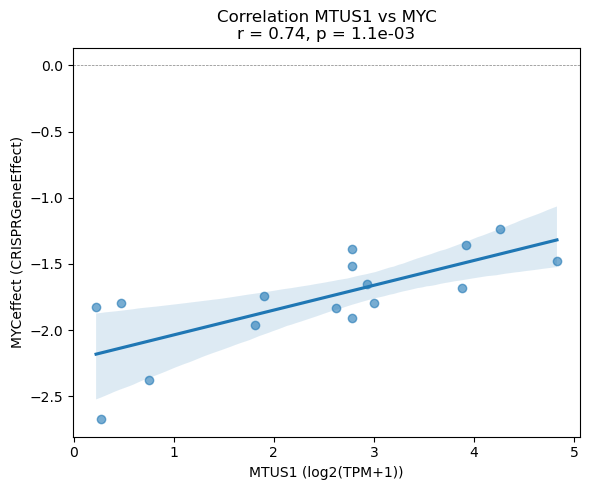

In [10]:
from src.Depmap_utils import plot_expr_vs_effect

plot_expr_vs_effect(effect_df, expression_df,'MTUS1','MYC')

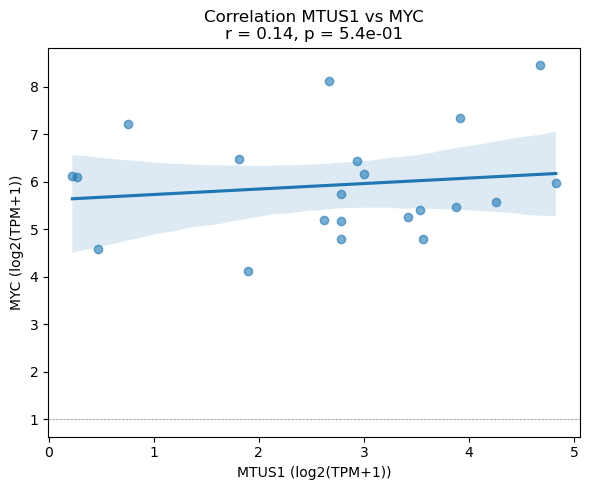

In [11]:
from src.Depmap_utils import plot_expr_vs_expression

plot_expr_vs_expression( expression_df,'MTUS1','MYC')

# 4. Pathways enrichment on putative targets 

ORA with Hallmark pathways

In [12]:
# default: Human
import gseapy as gp

gene_list = selected_correlations_all[(selected_correlations_all['P-value']< 0.05) & (selected_correlations_all['Correlation'] > 0)& (selected_correlations_all['min_score'] < -1)  ]['Gene'].unique().tolist()
#gene_list_chronos#
print("Number of genes:", len(gene_list))

enr = gp.enrichr(
    gene_list=gene_list,
    gene_sets='MSigDB_Hallmark_2020', 
    organism='Human',
    outdir=None,
)

enr.res2d[['Term','Adjusted P-value','Overlap','Combined Score','Genes']]

Number of genes: 55


,Term,Adjusted P-value,Overlap,Combined Score,Genes
0,Myc Targets V2,0.009820,3/58,156.764148,MYC;PPAN;FARSA
1,Myc Targets V1,0.020000,4/200,48.280112,MYC;TCP1;SERBP1;RPL14
2,Unfolded Protein Response,0.022327,3/113,58.191239,IMP3;DDX10;EEF2
3,Angiogenesis,0.281126,1/36,24.856811,FGFR1
4,Allograft Rejection,0.281126,2/200,8.489223,RPS3A;WARS1
5,mTORC1 Signaling,0.281126,2/200,8.489223,PSMB5;WARS1
6,Wnt-beta Catenin Signaling,0.281126,1/42,19.898736,MYC
7,Interferon Alpha Response,0.425077,1/97,5.546370,WARS1
8,UV Response Dn,0.425077,1/144,2.856111,MYC
9,DNA Repair,0.425077,1/150,2.658554,DCTN4
